64657852
64652771


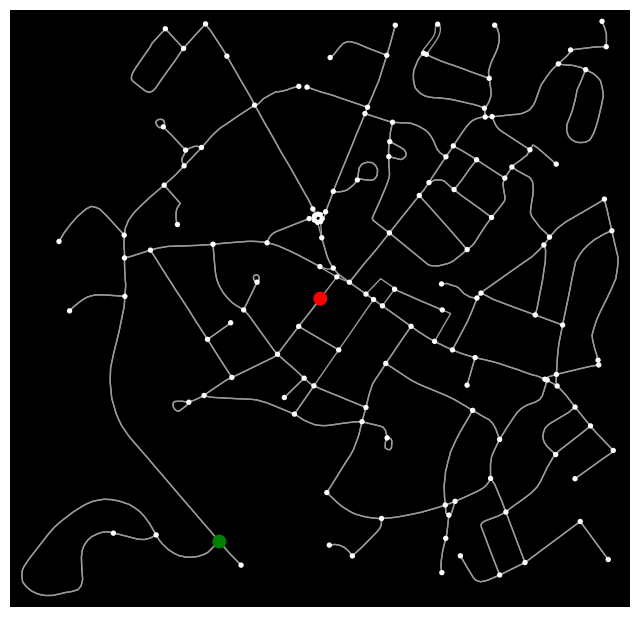

In [ ]:
import json
import copy
import math
from dataclasses import dataclass
from typing import TypeAlias

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib

import osmnx as ox
from IPython.display import HTML

ox.settings.use_cache = True
ox.settings.cache_folder = './cache' 

address = "Cary Memorial Library, 1874 Massachusetts Ave, Lexington, MA 02420"

try:
    G = ox.graph_from_address(address, dist=800, network_type="drive")
    start_node = ox.distance.nearest_nodes(G, X=-71.2299, Y=42.4479)
    print(start_node)
    end_node = ox.distance.nearest_nodes(G, X=-71.2328, Y=42.4429)
    print(end_node)
    node_colors = ['red' if node == start_node else 'green' if node == end_node else 'white' for node in G.nodes()]
    node_sizes = [100 if node == start_node or node == end_node  else 15 for node in G.nodes()]

    adj_dict = {
        int(u): {int(v): round(float(d[0]['length']), 2) for v, d in nbrs.items()}
        for u, nbrs in G.adj.items()
    }

    fig, ax = ox.plot_graph(
        G, 
        node_color=node_colors, 
        node_size=node_sizes, 
        node_zorder=3, 
        bgcolor='black'
    )
    plt.show()

except Exception as e:
    print(f"An error occurred: {e}")

In [ ]:
Vertex: TypeAlias = int
Weight: TypeAlias = int | float

@dataclass
class Edge:
    vertex: Vertex
    weight: Weight

Neighbors: TypeAlias = dict[Edge]

# Graph Library

def graph_get_neighbors(vertex: Vertex, adj_dict: dict[Vertex, Neighbors]) -> Neighbors:
    return adj_dict[int(vertex)].copy()

def graph_hasmore_neighbors(nbors: Neighbors) -> bool:
    return len(nbors) > 0

def graph_next_neighbor_edge(nbors: Neighbors) -> Edge:
    key, weight = next(iter(nbors.items()))
    nbors.pop(key)
    return Edge(vertex=key, weight=weight)

def graph_next_neighbor_key(nbors: Neighbors) -> Vertex:
    key, weight = next(iter(nbors.items()))
    nbors.pop(key)
    return key

In [3]:
nbors = graph_get_neighbors(64657852, adj_dict)
while graph_hasmore_neighbors(nbors):
    print(graph_next_neighbor_edge(nbors))


Edge(vertex='472421843', weight=78.06)
Edge(vertex='64656625', weight=100.74)


In [4]:
# DFS implementation
def dfs(start: Vertex, end: Vertex) -> bool:
    visited: set[Vertex] = set()

    def dfs_helper(current: Vertex, target: Vertex, visited: set[Vertex]) -> bool:
        if current == target:
            return True
        
        visited.add(current)
        nbors = graph_get_neighbors(current)
        
        while graph_hasmore_neighbors(nbors):
            neighbor = graph_next_neighbor_key(nbors)

            if neighbor not in visited:
                if dfs_helper(neighbor, target, visited):
                    return True
        return False
    
    return dfs_helper(start, end, visited)

Path found with 54 nodes.


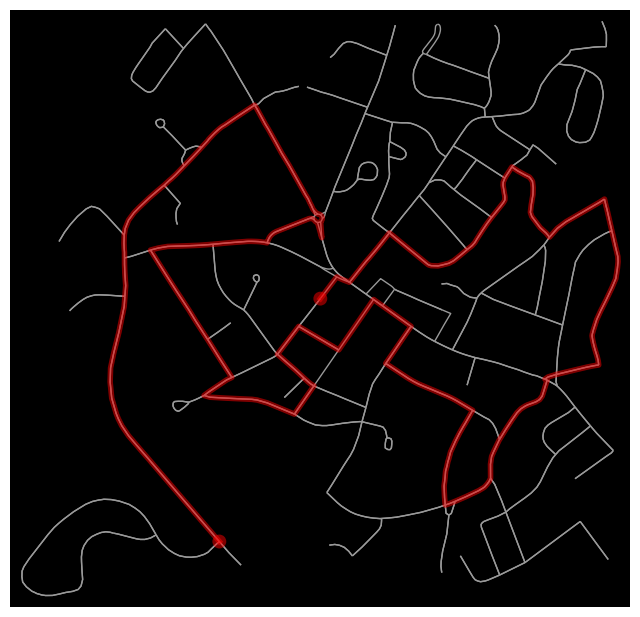

In [5]:
# DFS impementation - saves path and displays it
def dfs_with_path(start, end):
    visited = set()
    path = []
    
    def dfs_helper(current, target, visited, path):
        visited.add(current)
        path.append(int(current))
        
        if int(current) == int(target):
            return True
        
        nbors = graph_get_neighbors(int(current), adj_dict)
        while graph_hasmore_neighbors(nbors):
            neighbor = graph_next_neighbor_key(nbors)
            if neighbor not in visited:
                if dfs_helper(neighbor, target, visited, path):
                    return True
                
        path.pop()
        return False

    success = dfs_helper(str(start), str(end), visited, path)
    return path if success else None

def visualize_dfs_route(G, path):
    if not path:
        print("No path found between the specified nodes.")
        return

    print(f"Path found with {len(path)} nodes.")
    
    fig, ax = ox.plot_graph_route(
        G, 
        path, 
        route_color="red", 
        route_linewidth=4, 
        node_size=0, 
        bgcolor='black'
    )
    plt.show()

path_nodes = dfs_with_path(start_node, end_node)
visualize_dfs_route(G, path_nodes)

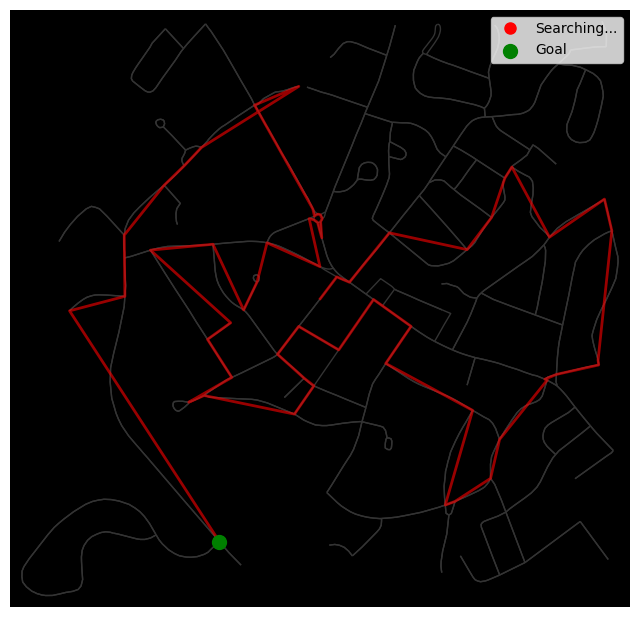

In [6]:
# DFS animation

def animate_dfs(G, start_node, end_node):
    visited = set()
    visit_order = []
    matplotlib.rcParams['animation.embed_limit'] = 1000.0
    def dfs_recorder(current, target):
        if current in visited:
            return False
        
        visited.add(current)
        visit_order.append(current)
        
        if int(current) == int(target):
            return True
        
        nbors = graph_get_neighbors(int(current), adj_dict)
        while graph_hasmore_neighbors(nbors):
            neighbor = graph_next_neighbor_key(nbors)
            if neighbor not in visited:
                if dfs_recorder(neighbor, target):
                    return True
        return False

    dfs_recorder(str(start_node), str(end_node))

    fig, ax = ox.plot_graph(G, node_size=0, edge_color='#333333', bgcolor='black', show=False, close=False)
    
    search_dot, = ax.plot([], [], 'ro', markersize=8, label='Searching...')
    path_line, = ax.plot([], [], color='red', linewidth=2, alpha=0.6)
    target_node = G.nodes[int(end_node)]
    ax.scatter(target_node['x'], target_node['y'], c='green', s=100, label='Goal', zorder=5)

    x_coords = [G.nodes[int(node)]['x'] for node in visit_order]
    y_coords = [G.nodes[int(node)]['y'] for node in visit_order]

    def init():
        search_dot.set_data([], [])
        path_line.set_data([], [])
        return search_dot, path_line

    def update(frame):
        search_dot.set_data([x_coords[frame]], [y_coords[frame]])
        path_line.set_data(x_coords[:frame+1], y_coords[:frame+1])
        return search_dot, path_line
    ani = FuncAnimation(fig, update, frames=len(visit_order), 
                        init_func=init, blit=True, interval=50)
    
    plt.legend()
    return ani

ani = animate_dfs(G, start_node, end_node)
ani.save('dfs_animation.gif', writer='pillow', fps=20)
HTML(ani.to_jshtml())

In [8]:
# Priority queue Library
@dataclass
class D_Vertex:
    vertex: Vertex
    distance: float

import heapq

def enq(pq: list, d: D_Vertex):
    heapq.heappush(pq, (d.distance, d.vertex))

def deq(pq: list) -> D_Vertex:
    if not pq:
        print("Queue empty.")
        exit()
    
    dist, v_id = heapq.heappop(pq)
    return D_Vertex(vertex=v_id, distance=dist)

def is_empty(pq: list) -> bool:
    return len(pq) == 0

Path found with 11 nodes.


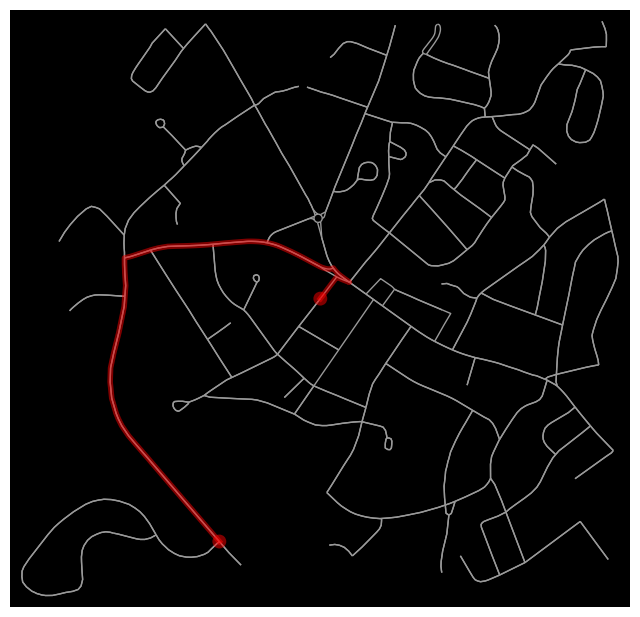

In [ ]:
# dijkstra's
parents = {}
dist = {}
for node in G.nodes():
    dist[int(node)] = math.inf

dist[start_node] = 0
to_visit: list[D_Vertex] = []
enq(to_visit, D_Vertex(start_node, 0))

while not is_empty(to_visit):
    d_vertex = deq(to_visit)

    if d_vertex.distance > dist[d_vertex.vertex]:
        continue

    nbors = graph_get_neighbors(d_vertex.vertex, adj_dict)
    while graph_hasmore_neighbors(nbors):
        edge = graph_next_neighbor_edge(nbors)
        candidate_weight = d_vertex.distance + edge.weight
        
        v_id = int(edge.vertex)
        if dist[v_id] > candidate_weight:
            dist[v_id] = candidate_weight
            parents[v_id] = d_vertex.vertex
            enq(to_visit, D_Vertex(vertex=v_id, distance=candidate_weight))

if end_node not in parents:
    print("No path exists!")
    path_nodes = []
else:
    path_nodes = []
    node = end_node
    while node is not None:
        path_nodes.append(node)
        node = parents.get(node)
    path_nodes.reverse()

visualize_dfs_route(G, path_nodes)